# Hotels in Amsterdam

This Notebook shows the conditional probability of hotels in Amsterdam being highly rated (binary dependent variable), conditional on distance from city center and stars (explanatory variables)

In [2]:
#importing libraries
import pandas as pd
import statsmodels.formula.api as smf
from stargazer.stargazer import Stargazer
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from statsmodels.nonparametric.smoothers_lowess import lowess
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import log_loss
import seaborn as sns
from plotnine import ggplot

## Data Work

In [3]:
#reading csv files
hotel_features = pd.read_csv('hotels-europe_features.csv')
hotel_prices = pd.read_csv('hotels-europe_price.csv')

In [4]:
# Break down of accommodation each city has
with pd.option_context('display.max_rows', None):
    
    unique_city_counts = hotel_features.groupby(['city', 'accommodation_type']).size().reset_index(name='hotel_count')
    
    print(unique_city_counts)
    
# Amsterdam has 341 hotels in the dataset

               city   accommodation_type  hotel_count
0         Amsterdam          Apart-hotel            2
1         Amsterdam            Apartment           48
2         Amsterdam    Bed and breakfast            9
3         Amsterdam          Guest House            6
4         Amsterdam               Hostel           21
5         Amsterdam                Hotel          341
6         Amsterdam           House boat            1
7         Amsterdam                  Inn            1
8            Athens        All inclusive            1
9            Athens          Apart-hotel           27
10           Athens            Apartment           30
11           Athens    Bed and breakfast            2
12           Athens              Cottage            1
13           Athens        Country House            1
14           Athens          Guest House            6
15           Athens               Hostel            7
16           Athens                Hotel          280
17           Athens         

In [8]:
#df1 where city is Amsterdam and accommodation_type is Hotel
df1 = pd.DataFrame(hotel_features)
df1 = df1.loc[(df1['city'] == 'Amsterdam') & (df1['accommodation_type'] == 'Hotel')]
df1.head()

,hotel_id,city,distance,stars,rating,country,city_actual,rating_reviewcount,center1label,center2label,neighbourhood,ratingta,ratingta_count,distance_alter,accommodation_type
0,1,Amsterdam,3.1,4.0,4.3,Netherlands,Amsterdam,1030.0,City centre,Montelbaanstoren,Amsterdam,4.0,1115.0,3.6,Hotel
2,3,Amsterdam,1.5,4.0,4.1,Netherlands,Amsterdam,165.0,City centre,Montelbaanstoren,Amsterdam,4.0,674.0,1.4,Hotel
3,4,Amsterdam,1.9,3.0,3.5,Netherlands,Amsterdam,298.0,City centre,Montelbaanstoren,Amsterdam,3.5,1882.0,2.1,Hotel
4,5,Amsterdam,1.8,3.5,4.0,Netherlands,Amsterdam,4.0,City centre,Montelbaanstoren,Amsterdam,4.5,66.0,2.0,Hotel
5,6,Amsterdam,1.9,4.0,4.1,Netherlands,Amsterdam,310.0,City centre,Montelbaanstoren,Amsterdam,4.0,767.0,2.0,Hotel


In [9]:
#seeing df2
df2 = pd.DataFrame(hotel_prices)
df2.head()

,hotel_id,price,offer,offer_cat,year,month,weekend,holiday,nnights,scarce_room
0,1,172,0,0% no offer,2017,11,1,0,1,0
1,1,122,1,15-50% offer,2018,1,1,0,1,0
2,1,122,1,15-50% offer,2017,12,0,1,1,0
3,1,552,1,1-15% offer,2017,12,0,1,4,0
4,1,122,1,15-50% offer,2018,2,1,0,1,0


In [12]:
#merging 2 dfs 
df = pd.merge(df1, df2, on = 'hotel_id')
df.head()

,hotel_id,city,distance,stars,rating,country,city_actual,rating_reviewcount,center1label,center2label,...,accommodation_type,price,offer,offer_cat,year,month,weekend,holiday,nnights,scarce_room
0,1,Amsterdam,3.1,4.0,4.3,Netherlands,Amsterdam,1030.0,City centre,Montelbaanstoren,...,Hotel,172,0,0% no offer,2017,11,1,0,1,0
1,1,Amsterdam,3.1,4.0,4.3,Netherlands,Amsterdam,1030.0,City centre,Montelbaanstoren,...,Hotel,122,1,15-50% offer,2018,1,1,0,1,0
2,1,Amsterdam,3.1,4.0,4.3,Netherlands,Amsterdam,1030.0,City centre,Montelbaanstoren,...,Hotel,122,1,15-50% offer,2017,12,0,1,1,0
3,1,Amsterdam,3.1,4.0,4.3,Netherlands,Amsterdam,1030.0,City centre,Montelbaanstoren,...,Hotel,552,1,1-15% offer,2017,12,0,1,4,0
4,1,Amsterdam,3.1,4.0,4.3,Netherlands,Amsterdam,1030.0,City centre,Montelbaanstoren,...,Hotel,122,1,15-50% offer,2018,2,1,0,1,0


In [13]:
#use hotel user ratings to create a binary variable: highly_rated=1 if rating ≥ 4, 0 otherwise 0 .
#Examine how high rating is related to the other hotel features in the data. Make sure to
#document and argue for the data cleaning/filtering decisions you make.
df.columns

Index(['hotel_id', 'city', 'distance', 'stars', 'rating', 'country',
       'city_actual', 'rating_reviewcount', 'center1label', 'center2label',
       'neighbourhood', 'ratingta', 'ratingta_count', 'distance_alter',
       'accommodation_type', 'price', 'offer', 'offer_cat', 'year', 'month',
       'weekend', 'holiday', 'nnights', 'scarce_room'],
      dtype='object')

In [14]:
#creating dummy variable
df['highly_rated'] = (df['rating'] >= 4).astype(int)
df = df.dropna(subset=['rating'])

In [15]:
df.highly_rated

0       1
1       1
2       1
3       1
4       1
       ..
1832    0
1833    0
1834    0
1835    0
1836    0
Name: highly_rated, Length: 1827, dtype: int64

In [16]:
#dropping na values for distance and stars
df = df.dropna(subset=['distance'])
df = df.dropna(subset=['stars'])

In [38]:
df.head()

,hotel_id,city,distance,stars,rating,country,city_actual,rating_reviewcount,center1label,center2label,...,year,month,weekend,holiday,nnights,scarce_room,highly_rated,pred_lpm,pred_logit,pred_probit
0,1,Amsterdam,3.1,4.0,4.3,Netherlands,Amsterdam,1030.0,City centre,Montelbaanstoren,...,2017,11,1,0,1,0,1,0.803467,0.873661,0.866938
1,1,Amsterdam,3.1,4.0,4.3,Netherlands,Amsterdam,1030.0,City centre,Montelbaanstoren,...,2018,1,1,0,1,0,1,0.803467,0.873661,0.866938
2,1,Amsterdam,3.1,4.0,4.3,Netherlands,Amsterdam,1030.0,City centre,Montelbaanstoren,...,2017,12,0,1,1,0,1,0.803467,0.873661,0.866938
3,1,Amsterdam,3.1,4.0,4.3,Netherlands,Amsterdam,1030.0,City centre,Montelbaanstoren,...,2017,12,0,1,4,0,1,0.803467,0.873661,0.866938
4,1,Amsterdam,3.1,4.0,4.3,Netherlands,Amsterdam,1030.0,City centre,Montelbaanstoren,...,2018,2,1,0,1,0,1,0.803467,0.873661,0.866938


## Linear Probability Model (LPM): `distance and stars`

In [20]:
x_vars = sm.add_constant(df[['distance', 'stars']])
# Model LPM
model = sm.OLS(df['highly_rated'], x_vars)
# Fit the model
# Have to control for heteroskedasticity with LPM:
result1 = model.fit(cov_type = 'HC1')
# Print summary
print(result1.summary())

                            OLS Regression Results                            
Dep. Variable:           highly_rated   R-squared:                       0.383
Model:                            OLS   Adj. R-squared:                  0.383
Method:                 Least Squares   F-statistic:                     1357.
Date:                Mon, 04 Dec 2023   Prob (F-statistic):               0.00
Time:                        15:54:41   Log-Likelihood:                -851.39
No. Observations:                1827   AIC:                             1709.
Df Residuals:                    1824   BIC:                             1725.
Df Model:                           2                                         
Covariance Type:                  HC1                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.5124      0.025    -20.836      0.0

### Analysis:

-(constant coefficient) the constant coefficient doesn't seem to have an interpretable meaning here. It is also negative (despite the depedent variable ranging from 0-1 (limitations of LPM)).

-(distance coefficient) for one unit increase in distance, hotels are more likely to be highly rated by 2.67 percentage points. p value is 0 (or near 0) meaning `distance` is statistically significant (most likely a relationship between distance and probability of a hotel being highly_rated (having more than 4 stars)).

-(stars coefficient) for one unit increase in stars, hotels are more likely to be highly raetd by 30.83 percentage points. p value is 0 (or near 0) meaning `stars` is statistically significant (most likely a relationship between stars and probability of a hotel being highly_rated (having more than 4 stars)).


In [21]:
# Limitations of LPM: coefficients can fall out of the range of [0,1] which doesn't make sense for 
# our dependent variable (as seen with the constant coefficient). This model also assumes linearity which is why it is better to use the logit or probit
# models. 

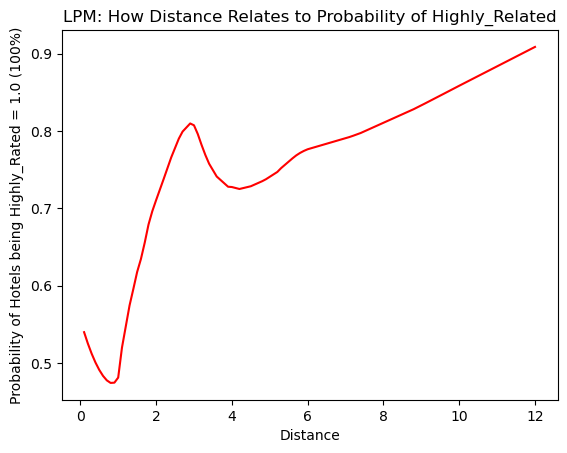

In [25]:
#Linear Probability Model (LPM) 
data_distance = lowess(df['highly_rated'], df['distance'])
# Plot the smoothed data
plt.plot(data_distance[:, 0], data_distance[:, 1], color='red', label='Distance')
plt.xlabel('Distance')
plt.ylabel('Probability of Hotels being Highly_Rated = 1.0 (100%)')
plt.title('LPM: How Distance Relates to Probability of Highly_Related')
plt.show()

The line represents an estimate of the relationship between 'distance' and the probability of hotels highly rated. For the most part, the line is increasing, suggesting a positive relationship: as 'distance' increases, the probability of being highly rated also increases.

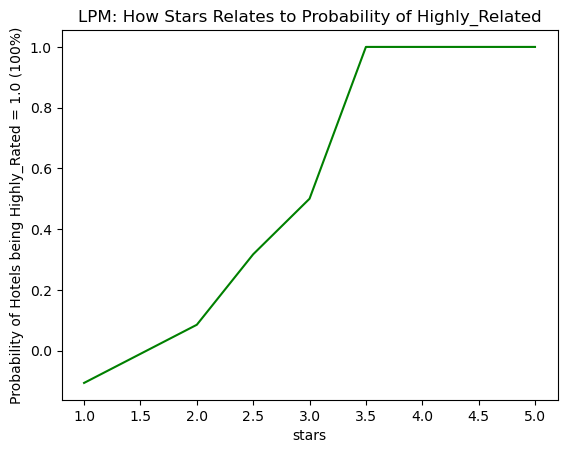

In [26]:
#Linear Probability Model (LPM) 
data_distance = lowess(df['highly_rated'], df['stars'])
# Plot the smoothed data
plt.plot(data_distance[:, 0], data_distance[:, 1], color='green', label='Distance')
plt.xlabel('stars')
plt.ylabel('Probability of Hotels being Highly_Rated = 1.0 (100%)')
plt.title('LPM: How Stars Relates to Probability of Highly_Related')
plt.show()

The line represents an estimate of the relationship between 'stars' and the probability of hotels highly rated. For the most part, the line is increasing, suggesting a positive relationship: as 'stars' increases, the probability of being highly rated also increases. However, the line plateaus at 3.5 stars (the probability of hotels being highly rated stays constant from 3.5 stars onward).

## Logit Regression

In [27]:
#Logit Regression Results (table)
#x_variable + covariate
x_vars = df[['distance', 'stars']]
#adding intercept/constant
x_vars = sm.add_constant(x_vars)
#modeling Logit
model = sm.Logit(df['highly_rated'], x_vars)
#robust SE 
result2 = model.fit(cov_type = 'HC1')
print(result2.summary())

Optimization terminated successfully.
         Current function value: 0.440007
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:           highly_rated   No. Observations:                 1827
Model:                          Logit   Df Residuals:                     1824
Method:                           MLE   Df Model:                            2
Date:                Mon, 04 Dec 2023   Pseudo R-squ.:                  0.3483
Time:                        15:56:24   Log-Likelihood:                -803.89
converged:                       True   LL-Null:                       -1233.6
Covariance Type:                  HC1   LLR p-value:                2.377e-187
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -6.9364      0.331    -20.951      0.000      -7.585      -6.287
distance       0.1387      0.

Logit Regression Model coefficients are not very informative as they represent log-odds. We need marginal differences in order to make sense of our model.

In [28]:
marginal_effects = result2.get_margeff()

In [29]:
# Print marginal effects summary
print(marginal_effects.summary())

        Logit Marginal Effects       
Dep. Variable:           highly_rated
Method:                          dydx
At:                           overall
                dy/dx    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
distance       0.0199      0.004      5.037      0.000       0.012       0.028
stars          0.3023      0.007     43.999      0.000       0.289       0.316


### Analysis:

-(distance coefficient) for one unit increase in distance, hotels are more likely to be highly rated by 1.99 percentage points. p value is 0 (or near 0) meaning `distance` is statistically significant (most likely a relationship between distance and probability of a hotel being highly_rated (having more than 4 stars)).

-(stars coefficient) for one unit increase in stars, hotels are more likely to be highly raetd by 30.23 percentage points. p value is 0 (or near 0) meaning `stars` is statistically significant (most likely a relationship between stars and probability of a hotel being highly_rated (having more than 4 stars)).

In [30]:
predicted_probabilities2 = result2.predict(x_vars)
predicted_probabilities2.mean()
#predicted probability is around 0.5 = it indicates uncertainty or ambiguity in predicting the outcome.

0.5944170771756979

## Probit Regression

In [31]:
#Probit
#x_variable + covariate
x_vars = df[['distance', 'stars']]
#adding intercept/constant
x_vars = sm.add_constant(x_vars)
#modeling Logit
model = sm.Probit(df['highly_rated'], x_vars)
#robust SE 
result3 = model.fit(cov_type = 'HC1')
print(result3.summary())

Optimization terminated successfully.
         Current function value: 0.439729
         Iterations 6
                          Probit Regression Results                           
Dep. Variable:           highly_rated   No. Observations:                 1827
Model:                         Probit   Df Residuals:                     1824
Method:                           MLE   Df Model:                            2
Date:                Mon, 04 Dec 2023   Pseudo R-squ.:                  0.3488
Time:                        15:57:04   Log-Likelihood:                -803.39
converged:                       True   LL-Null:                       -1233.6
Covariance Type:                  HC1   LLR p-value:                1.432e-187
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -4.0404      0.175    -23.024      0.000      -4.384      -3.696
distance       0.0713      0.

In [32]:
marginal_effects = result3.get_margeff()

In [33]:
# Print marginal effects summary
print(marginal_effects.summary())

       Probit Marginal Effects       
Dep. Variable:           highly_rated
Method:                          dydx
At:                           overall
                dy/dx    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
distance       0.0176      0.004      4.631      0.000       0.010       0.025
stars          0.3045      0.007     46.036      0.000       0.292       0.317


### Analysis:

-(distance coefficient) for one unit increase in distance, hotels are more likely to be highly rated by 1.76 percentage points. p value is 0 (or near 0) meaning `distance` is statistically significant (most likely a relationship between distance and probability of a hotel being highly_rated (having more than 4 stars)).

-(stars coefficient) for one unit increase in stars, hotels are more likely to be highly raetd by 30.45 percentage points. p value is 0 (or near 0) meaning `stars` is statistically significant (most likely a relationship between stars and probability of a hotel being highly_rated (having more than 4 stars)).


In [34]:
predicted_probabilities3 = result3.predict(x_vars)
predicted_probabilities3.mean()
#predicted probability is around 0.5 = it indicates uncertainty or ambiguity in predicting the outcome.

0.5926295068865443

### Fit of Predicted Probabilities

In [35]:
df["pred_lpm"] = result1.predict()
df["pred_logit"] = result2.predict()
df["pred_probit"] = result3.predict()

In [36]:
#Fit of predicted probabilities:
pd.DataFrame(
    {
        "R-squared": [
            result1.rsquared,
            r2_score(df["highly_rated"], df["pred_logit"]),
            r2_score(df["highly_rated"], df["pred_probit"]),
        ],
        "Brier-score": [
            mean_squared_error(df["highly_rated"], df["pred_lpm"]),
            mean_squared_error(df["highly_rated"], df["pred_logit"]),
            mean_squared_error(df["highly_rated"], df["pred_probit"]),
        ],}, index=["LPM", "Logit", "Probit"],).T.round(3)


,LPM,Logit,Probit
R-squared,0.383,0.406,0.404
Brier-score,0.149,0.143,0.144


Logit and Probit models to predict probability of being highly rated have the best fit (highest R-squared scores /lowest Brier-score in comparison to LPM)

### Summary:

Distance from city center and Stars seem to both have a positive relationship with hotels being highly rated. This was expected from stars, but not from distance. However, both variables are statistically significant and therefore we can assume the relationship is meaningful and can be generalized to the population of all hotels in Amsterdam. 